In [1]:
# -*- coding: utf-8 -*-
"""
Based on code from
    https://colab.research.google.com/github/spmallick/learnopencv/blob/master/PyTorch-Segmentation-torchvision/intro-seg.ipynb
"""

'\nBased on code from\n    https://colab.research.google.com/github/spmallick/learnopencv/blob/master/PyTorch-Segmentation-torchvision/intro-seg.ipynb\n'

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import PIL
from torchvision import models
import numpy as np
import torchvision.transforms as T
import cv2

In [3]:
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
                             # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0),
                             # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0),
                             # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (255, 0, 0),
                             # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)])
    
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
        
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [4]:
def apply_mask(im, im_pred):
    """
    Overlays the predicted class labels onto an image using the alpha channel.
    This function assumes that the background label is the black color.
    This function is provided as an inspiration for the masking function you should write.
    """
    r_channel, g_channel, b_channel = cv2.split(im_pred)
    alpha_channel = 127 * np.ones(b_channel.shape, dtype=b_channel.dtype)
    # Make background pixels fully transparent
    alpha_channel -= 127 * np.all(im_pred == np.array([0, 0, 0]), axis=2).astype(b_channel.dtype)
    im_pred = cv2.merge((r_channel, g_channel, b_channel, alpha_channel))
    mask = Image.fromarray(im_pred, mode='RGBA')
    masked_img = Image.fromarray(im)
    masked_img.paste(mask, box=None, mask=mask)
    return np.array(masked_img)

In [5]:
# define the model
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

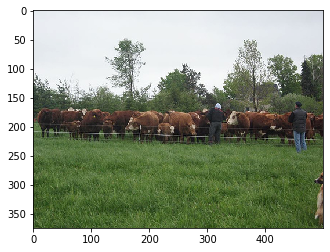

In [6]:
# load an image
img = Image.open('YANSE@TCD.IE.png')
plt.imshow(img); plt.show()

In [7]:
# transform the image
trf = T.Compose([T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [8]:
# pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 375, 500])


In [9]:
# calculate labels
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (np.unique(om))

[ 0 10 13 15 17]


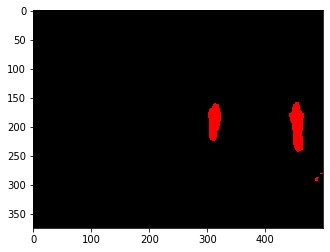

In [10]:
# show segmentation output
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [11]:
img = np.array(img)

In [12]:
print('IMG:\n Shape =', img.shape, '\n Max =', img.max(), '\n Min =', img.min())
print('RGB:\n Shape =', rgb.shape, '\n Max =', rgb.max(), '\n Min =', rgb.min())

IMG:
 Shape = (375, 500, 3) 
 Max = 255 
 Min = 0
RGB:
 Shape = (375, 500, 3) 
 Max = 255 
 Min = 0


In [13]:
fusion = cv2.addWeighted(img,0.5,rgb,0.5,0)

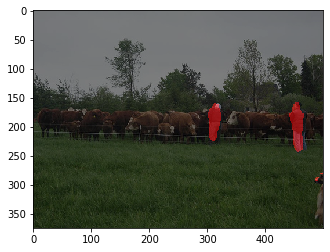

In [14]:
plt.imshow(fusion)

Text(0.5, 1.0, 'Predicted Image')

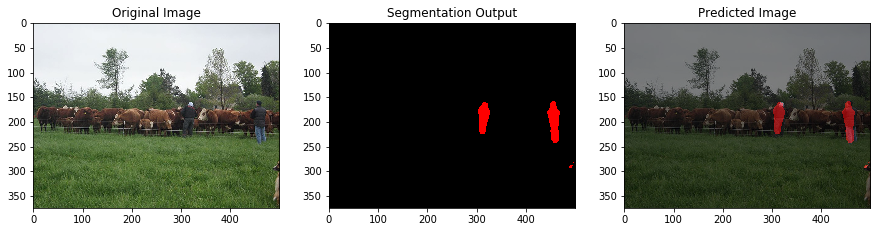

In [15]:
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(rgb)
plt.title('Segmentation Output')
plt.subplot(133)
plt.imshow(fusion)
plt.title('Predicted Image')

In [17]:
plt.imsave('YANSE@TCD.IE_predicted.png', fusion)
np.save('rgb.npy', rgb)